# Deep Image Prior (DIP) for PAM - Evaluation
## Tri Vu - Updated 031521

### Import libs and utils

In [1]:
import keras
from keras import backend as K
import tensorflow as tf
from define_model import *
from build_unet import *
from utils import *
from keras.optimizers import Adam
import os
from os.path import isfile, join
from numba import cuda
import cv2
from scipy.stats import ttest_ind, ttest_ind_from_stats
import statsmodels.stats.multicomp as mc

Using TensorFlow backend.


In [2]:
""" Choose which gpu to run the training """
gpu = 1  # 0 for first gpu, 1 for 2nd gpu
if gpu == 0:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
elif gpu == 1:
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Mode Selection

In [3]:
LOG_READ = False  # Read log 
SSIM_EVAL = True

### Read log

In [4]:
if LOG_READ:
    imgpath = './Data/10_5/output/'
    imgname = '20190423_thinnedskull_Epi 11_Image1_index0_pad_5-10'
    im = cv2.imread(imgpath + imgname + '_dip_out.png')
    l = np.loadtxt(imgpath + imgname + '_loss.txt')

    plt.plot(l)
    plt.yscale('log')
    plt.show()

### Fig 4

In [5]:
# imgroot = './Data/brain_map_all_patterns'
# pattern = ['4_1', '5_1', '6_1', '7_3', '10_5']
# count_p = 1
# s_dip = np.zeros((len(pattern)))
# s_bilinear = np.zeros((len(pattern)))
# s_bicubic = np.zeros((len(pattern)))
# s_lanczos = np.zeros((len(pattern)))
# s_dl = np.zeros((len(pattern)))
# p_dip = np.zeros((len(pattern)))
# p_bilinear = np.zeros((len(pattern)))
# p_lanczos = np.zeros((len(pattern)))
# p_bicubic = np.zeros((len(pattern)))
# p_dl = np.zeros((len(pattern)))
# dip = np.zeros((600, 600, len(pattern)))
# bicubic = np.copy(dip)
# bilinear = np.copy(dip)
# lanczos = np.copy(dip)
# gt = np.copy(dip)
# dl = np.copy(dip)

# for i in pattern:
#     im = cv2.imread(imgroot + '/' + i + '/brain_map_' + i + '.png')
#     im2 = cv2.imread(imgroot + '/' + i + '/deep_learning/brain_map_' + i + '.png')
#     im2 = im2[:, :, 0]
#     im2 = cv2.resize(im2, (im.shape[1], im.shape[0]),
#                         interpolation=cv2.INTER_CUBIC)
#     im = im[round(im.shape[0]/2)-300:round(im.shape[0]/2)+300,round(im.shape[1]/2)-300:round(im.shape[1]/2)+300]
#     im_ori, im_gt, im_masked, im_mask, im_bicubic, factor, im_bilinear, im_lanczos = readImg(im)

#     im2 = im2[round(im2.shape[0]/2)-300:round(im2.shape[0]/2)+300,round(im2.shape[1]/2)-300:round(im2.shape[1]/2)+300]
#     im_dl = np.copy(im2)
#     im2 = cv2.imread(imgroot + '/' + i + '/output/brain_map_' + i + '_dip_out.png')
#     if im2 is None:
#         continue
#     im_dip = im2[:, :, 1]
    
#     # Save ssim values
#     s_dip[count_p-1] = ssim(im_dip, im_gt, data_range=255)
#     s_bicubic[count_p-1] = ssim(im_bicubic, im_gt, data_range=255)
#     s_dl[count_p-1] = ssim(im_dl, im_gt, data_range=255)
#     s_bilinear[count_p-1] = ssim(im_bilinear, im_gt, data_range=255)
#     s_lanczos[count_p-1] = ssim(im_lanczos, im_gt, data_range=255)

#     # Save psnr values
#     p_dip[count_p-1] = psnr(im_dip, im_gt)
#     p_bicubic[count_p-1] = psnr(im_bicubic, im_gt)
#     p_dl[count_p-1] = psnr(im_dl, im_gt)
#     p_bilinear[count_p-1] = psnr(im_bilinear, im_gt)
#     p_lanczos[count_p-1] = psnr(im_lanczos, im_gt)
    
#     # Save images
#     dip[:, :, count_p-1] = im_dip
#     bicubic[:, :, count_p-1] = im_bicubic
#     dl[:, :, count_p-1] = im_dl
#     bilinear[:, :, count_p-1] = im_bilinear
#     lanczos[:, :, count_p-1] = im_lanczos
#     gt[:, :, count_p-1] = im_gt
    
#     count_p += 1
    

In [6]:
# plt.imshow(dip[:,:,0])
# plt.show()
# plt.imshow(bicubic[:,:,0])
# plt.show()
# plt.imshow(gt[:,:,0])
# plt.show()

In [7]:
# print(s_bilinear)
# print(s_bicubic)
# print(s_lanczos)
# print(s_dl)
# print(s_dip)

In [8]:
# print(p_bilinear)
# print(p_bicubic)
# print(p_lanczos)
# print(p_dl)
# print(p_dip)

### Evaluate SSIM

In [9]:
imgroot = './Data'
pattern = ['4_1', '5_1', '6_1', '2_5', '7_3', '10_5', '6_12', '8_14']
pattern_n = ['[4,1]', '[5,1]', '[6,1]', '[2,5]', '[7,3]', '[10,5]', '[6,12]', '[8,14]']
# pattern = ['4_1', '5_1', '6_1', '7_3', '10_5']
# pattern_n = ['[4,1]', '[5,1]', '[6,1]', '[7,3]', '[10,5]']
metrics = ['SSIM', 'PSNR (dB)']
method = ['Bilinear', 'Lanczos', 'Bicubic', 'DIP', 'FD U-Net']
batch = 37

imgpath = imgroot + '/' + pattern[0]
list_dir = os.listdir(imgpath)
list_file = [f for f in list_dir if isfile(join(imgpath, f))]
prefix, suffix = list_file[0].split('.')
print(suffix)

png


In [10]:
count_p = 1
s_dip = np.zeros((len(pattern), batch))
s_bilinear = np.zeros((len(pattern), batch))
s_bicubic = np.zeros((len(pattern), batch))
s_lanczos = np.zeros((len(pattern), batch))
s_dl = np.zeros((len(pattern), batch))
p_dip = np.zeros((len(pattern), batch))
p_bilinear = np.zeros((len(pattern), batch))
p_lanczos = np.zeros((len(pattern), batch))
p_bicubic = np.zeros((len(pattern), batch))
p_dl = np.zeros((len(pattern), batch))
dip = np.zeros((300, 300, len(pattern), batch))
bicubic = np.copy(dip)
bilinear = np.copy(dip)
lanczos = np.copy(dip)
gt = np.copy(dip)
dl = np.copy(dip)

for p in pattern:
    count_f = 1
    imgpath = imgroot + '/' + p
    list_dir = os.listdir(imgpath)
    list_file = [f for f in list_dir if isfile(join(imgpath, f))]
    for f in list_file:        
#         print('Current count: ' + str(count_f))
#         print(f)
        
        imgname, imgsuffix = f.split('.')
        if imgsuffix != 'png':
            continue

        im = cv2.imread(imgpath + '/' + f)
        im2 = cv2.imread(imgpath + '/deep_learning/' + imgname + '.' + imgsuffix)
        print(imgpath + '/' + f)
        im2 = im2[:, :, 0]
        im2 = cv2.resize(im2, (im.shape[1], im.shape[0]),
                            interpolation=cv2.INTER_CUBIC)
        im = im[round(im.shape[0]/2)-150:round(im.shape[0]/2)+150,round(im.shape[1]/2)-150:round(im.shape[1]/2)+150]
        im_ori, im_gt, im_masked, im_mask, im_bicubic, factor, im_bilinear, im_lanczos = readImg(im)

        im2 = im2[round(im2.shape[0]/2)-150:round(im2.shape[0]/2)+150,round(im2.shape[1]/2)-150:round(im2.shape[1]/2)+150]
        im_dl = np.copy(im2)
        im2 = cv2.imread(imgpath + '/output/' + imgname + '_dip_out.' + imgsuffix)
        if im2 is None:
            continue
        im_dip = im2[:, :, 1]
        
        # Save ssim values
        s_dip[count_p-1, count_f-1] = ssim(im_dip, im_gt, data_range=255)
        s_bicubic[count_p-1, count_f-1] = ssim(im_bicubic, im_gt, data_range=255)
        s_dl[count_p-1, count_f-1] = ssim(im_dl, im_gt, data_range=255)
        s_bilinear[count_p-1, count_f-1] = ssim(im_bilinear, im_gt, data_range=255)
        s_lanczos[count_p-1, count_f-1] = ssim(im_lanczos, im_gt, data_range=255)
        
        # Save psnr values
        p_dip[count_p-1, count_f-1] = psnr(im_dip, im_gt)
        p_bicubic[count_p-1, count_f-1] = psnr(im_bicubic, im_gt)
        p_dl[count_p-1, count_f-1] = psnr(im_dl, im_gt)
        p_bilinear[count_p-1, count_f-1] = psnr(im_bilinear, im_gt)
        p_lanczos[count_p-1, count_f-1] = psnr(im_lanczos, im_gt)
        
        # Save images
        dip[:, :, count_p-1, count_f-1] = im_dip
        bicubic[:, :, count_p-1, count_f-1] = im_bicubic
        dl[:, :, count_p-1, count_f-1] = im_dl
        bilinear[:, :, count_p-1, count_f-1] = im_bilinear
        lanczos[:, :, count_p-1, count_f-1] = im_lanczos
        gt[:, :, count_p-1, count_f-1] = im_gt

        count_f += 1
        if count_f > batch:
            break
    
    count_p += 1

./Data/4_1/190307_brain 1_Image0_index0_1-12_1-4.png
./Data/4_1/20190411_EpiInj_thinnedskull 2_Image0_index0_1-12_1-4.png
./Data/4_1/20190412_EpiInj_thinnedskull 3_Image0_index0_1-12_1-4.png
./Data/4_1/20190412_EpiInj_thinnedskull2 3_Image0_index0_1-12_1-4.png
./Data/4_1/20190423_thinnedskull_Epi 11_Image7_index0_1-12_1-4.png
./Data/4_1/20190425_thinnedskull_Epi 19_Image11_index0_1-12_1-4.png
./Data/4_1/20190516_practice&oldmice   4_Image1_index0_1-12_1-4.png
./Data/4_1/20190529_findfocus  24_Image0_index0_1-12_1-4.png
./Data/4_1/20190529_findfocus  24_Image12_index0_1-12_1-4.png
./Data/4_1/532_OR_398_index0_1-12_1-4.png
./Data/4_1/532_OR_39_index0_1-12_1-4.png
./Data/4_1/532_OR_40_index0_1-12_1-4.png
./Data/4_1/532_OR_542_index0_1-12_1-4.png
./Data/4_1/532_OR_545_index0_1-12_1-4.png
./Data/4_1/532_OR_57_index0_1-12_1-4.png
./Data/4_1/532_OR_59_index0_1-12_1-4.png
./Data/4_1/532_OR_63_index0_1-12_1-4.png
./Data/4_1/532_OR_64_index0_1-12_1-4.png
./Data/4_1/532_OR_71_index0_1-12_1-4.png


./Data/7_3/reslt_OR_2 (20)_index0_3-7.png
./Data/7_3/reslt_OR_2 (23)_index0_3-7.png
./Data/7_3/reslt_OR_2 (28)_index0_3-7.png
./Data/7_3/reslt_OR_2 (33)_index0_3-7.png
./Data/7_3/reslt_OR_2 (5)_index0_3-7.png
./Data/7_3/reslt_OR_3 (22)_index0_3-7.png
./Data/7_3/reslt_OR_4 (15)_index0_3-7.png
./Data/7_3/reslt_OR_4 (5)_index0_3-7.png
./Data/7_3/reslt_OR_5 (13)_index0_3-7.png
./Data/7_3/reslt_OR_5 (2)_index0_3-7.png
./Data/7_3/reslt_OR_7 (4)_index0_3-7.png
./Data/7_3/reslt_OR_9 (13)_index0_3-7.png
./Data/7_3/reslt_OR_9 (4)_index0_3-7.png
./Data/10_5/190307_brain 1_Image0_index0_5-10.png
./Data/10_5/20190411_EpiInj_thinnedskull 2_Image0_index0_5-10.png
./Data/10_5/20190412_EpiInj_thinnedskull 3_Image0_index0_5-10.png
./Data/10_5/20190412_EpiInj_thinnedskull2 3_Image0_index0_5-10.png
./Data/10_5/20190423_thinnedskull_Epi 11_Image7_index0_5-10.png
./Data/10_5/20190425_thinnedskull_Epi 19_Image11_index0_5-10.png
./Data/10_5/20190516_practice&oldmice   4_Image1_index0_5-10.png
./Data/10_5/2019

In [11]:
imgpath + '/deep_learning/' + imgname + '.' + imgsuffix

'./Data/8_14/deep_learning/reslt_OR_9 (4)_index0_14-8.png'

In [12]:
im.shape

(300, 300, 3)

In [13]:
# Multiple Student t-test WARNING: DONT USE THIS. ANOVA MUST BE USED FOR >2 GROUPS
def get_pval(d1, d2, n1, n2, idx, eol=False):
    t, p = ttest_ind(d1[idx, :], d2[idx, :], equal_var=False)
    if eol:
        print(pattern[idx], n1, n2, p, '\n')
    else:
        print(pattern[idx], n1, n2, p)
    return t, p
    
# Get p-value 
print('SSIM:')

for idx in range(-1, -len(pattern)-1, -1):
    get_pval(s_bicubic, s_dip, 'bicubic', 'dip', idx)
    if idx == -len(pattern):
        get_pval(s_dl, s_dip, 'dl', 'dip', idx)
        get_pval(s_dl, s_bicubic, 'dl', 'bicubic', idx, eol=True)
    else:
        get_pval(s_dl, s_dip, 'dl', 'dip', idx, eol=True)
        
print('PSNR:')

for idx in range(-1, -len(pattern)-1, -1):
    get_pval(p_bicubic, p_dip, 'bicubic', 'dip', idx)
    if idx == -len(pattern):
        get_pval(p_dl, p_dip, 'dl', 'dip', idx)
        get_pval(p_dl, p_bicubic, 'dl', 'bicubic', idx, eol=True)
    else:
        get_pval(p_dl, p_dip, 'dl', 'dip', idx, eol=True)

SSIM:
8_14 bicubic dip 0.3602902192854257
8_14 dl dip 0.20366291235551398 

6_12 bicubic dip 0.12157708727476124
6_12 dl dip 0.09950958644738093 

10_5 bicubic dip 2.604895205953353e-08
10_5 dl dip 0.011358237677990908 

7_3 bicubic dip 0.0010667226629125256
7_3 dl dip 0.03135801978650476 

2_5 bicubic dip 9.94784151738973e-10
2_5 dl dip 0.049341858456221306 

6_1 bicubic dip 8.65852292264822e-06
6_1 dl dip 0.4488491695614951 

5_1 bicubic dip 1.151945844529469e-06
5_1 dl dip 0.02863130256290048 

4_1 bicubic dip 0.018213851257749703
4_1 dl dip 0.00022218857262198063
4_1 dl bicubic 0.011199922463731787 

PSNR:
8_14 bicubic dip 0.6051696890203523
8_14 dl dip 0.2628838047501653 

6_12 bicubic dip 0.3712105272168329
6_12 dl dip 0.16144699674180607 

10_5 bicubic dip 0.0005733312753477016
10_5 dl dip 0.2837961775125476 

7_3 bicubic dip 0.03604120296057198
7_3 dl dip 0.3967307210925596 

2_5 bicubic dip 9.796439930429237e-07
2_5 dl dip 0.3789792274659982 

6_1 bicubic dip 0.000511373590280

In [14]:
# SSIM
s_stack = np.dstack((s_bilinear, s_bicubic, s_lanczos, s_dip, s_dl))
p_stack = np.dstack((p_bilinear, p_bicubic, p_lanczos, p_dip, p_dl))
s_label = ["           " for x in range(np.prod(s_stack.shape))]
s_label = np.reshape(s_label, (s_stack.shape))
print(s_label.dtype)
for i in range(s_stack.shape[-1]):
    s_label[:, :, i] = method[i]
    print(pattern[i])

# Get only bicubic, DIP and FDUNet
p_stack = np.dstack((p_stack[:, :, 2], p_stack[:, :, -2], p_stack[:, :, -1]))
s_stack = np.dstack((s_stack[:, :, 2], s_stack[:, :, -2], s_stack[:, :, -1]))
s_label = np.dstack((s_label[:, :, 2], s_label[:, :, -2], s_label[:, :, -1]))

<U11
4_1
5_1
6_1
2_5
7_3


In [15]:
# ANOVA with post-hoc Tukey - folllow the example in https://www.pythonfordatascience.org/anova-python/
# A good post on post-hoc tests with ANOVA: https://statisticsbyjim.com/anova/post-hoc-tests-anova/
# SSIM
idx = 4
print(pattern[idx])
comp = mc.MultiComparison(s_stack[idx, :, :].flatten(), s_label[idx, :, :].flatten())
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

7_3


group1,group2,meandiff,p-adj,lower,upper,reject
Bicubic,DIP,0.0597,0.001,0.0245,0.0948,True
Bicubic,FD U-Net,0.0878,0.001,0.0526,0.1229,True
DIP,FD U-Net,0.0281,0.1443,-0.0071,0.0632,False


In [16]:
# ANOVA with post-hoc Tukey - folllow the example in https://www.pythonfordatascience.org/anova-python/
# A good post on post-hoc tests with ANOVA: https://statisticsbyjim.com/anova/post-hoc-tests-anova/
# PSNR
idx = 3
print(pattern[idx])
comp = mc.MultiComparison(p_stack[idx, :, :].flatten(), s_label[idx, :, :].flatten())
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

2_5


group1,group2,meandiff,p-adj,lower,upper,reject
Bicubic,DIP,4.8078,0.001,2.6435,6.9721,True
Bicubic,FD U-Net,5.6615,0.001,3.4972,7.8258,True
DIP,FD U-Net,0.8537,0.6089,-1.3106,3.018,False


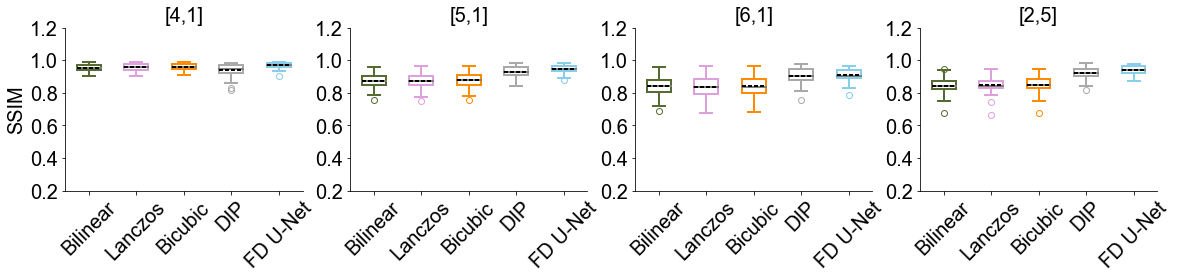

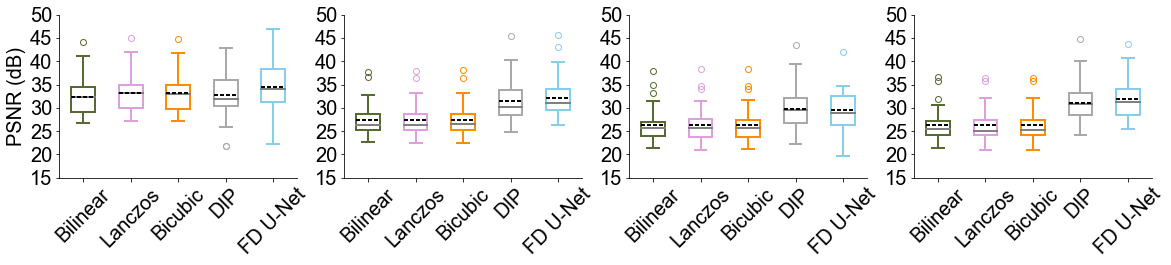

In [17]:
# Print subplots
method_c = ['darkolivegreen', 'plum', 'darkorange', 'darkgray', 'skyblue']
lw = 2
meanpointprops = dict(linewidth=lw, color='k', linestyle='-')
medianpointprops = dict(linewidth=lw, color='gray')
boxprops = dict(linewidth=lw)
flineprops = dict(linewidth=lw)
fname = 'Arial'
fsize = 20
for j in range(len(metrics)):
    fig = plt.figure(figsize=(40,3))
    for i in range(len(pattern)-4):
        ax = fig.add_subplot(1, len(pattern), i+1)
        if j == 0:
            ax.set_title(pattern_n[i], fontsize=fsize, fontname=fname)
            bp = plt.boxplot([s_bilinear[i, :], s_lanczos[i, :], s_bicubic[i, :], s_dip[i, :], s_dl[i, :]], 
                        boxprops=boxprops, medianprops=medianpointprops, whiskerprops=flineprops, capprops=flineprops,
                       showmeans=True, meanline=True, meanprops=meanpointprops, patch_artist=True)
            plt.ylim(top=1.2, bottom=0.2)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            for patch, flier, mean, color in zip(bp['boxes'], bp['fliers'], bp['means'], method_c):
                flier.set(markeredgecolor=color)
                mean.set_linestyle('--')
                mean.set_dashes((2, 1, 2, 1))
                patch.set_edgecolor(color)
                patch.set_facecolor('white')
            count = 0
            for wker, cap in zip(bp['whiskers'], bp['caps']):
                wker.set(color=method_c[count//2])
                cap.set(color=method_c[count//2])
                count += 1
        if j == 1:
            bp = plt.boxplot([p_bilinear[i, :], p_lanczos[i, :], p_bicubic[i, :], p_dip[i, :], p_dl[i, :]], 
                        boxprops=boxprops, medianprops=medianpointprops, whiskerprops=flineprops, capprops=flineprops,
                       showmeans=True, meanline=True, meanprops=meanpointprops, patch_artist=True)
            plt.ylim(top=50, bottom=15)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            for patch, flier, mean, color in zip(bp['boxes'], bp['fliers'], bp['means'], method_c):
                flier.set(markeredgecolor=color)
                mean.set_linestyle('--')
                mean.set_dashes((2, 1, 2, 1))
                patch.set_edgecolor(color)
                patch.set_facecolor('white')
            count = 0
            for wker, cap in zip(bp['whiskers'], bp['caps']):
                wker.set(color=method_c[count//2])
                cap.set(color=method_c[count//2])
                count += 1
        if i == 0:
            plt.ylabel(metrics[j], fontsize=fsize, fontname=fname)
        plt.xticks([1, 2, 3, 4, 5], method, 
                   fontsize=fsize, fontname=fname)
        plt.xticks(rotation=45)
        plt.yticks(fontsize=fsize, fontname=fname)
    
    plt.show()

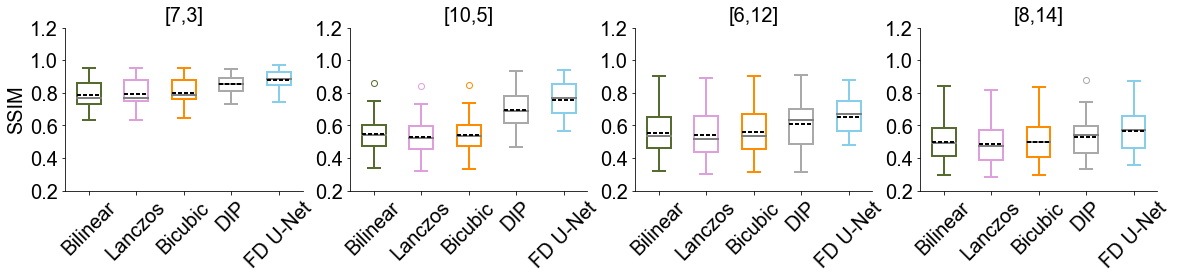

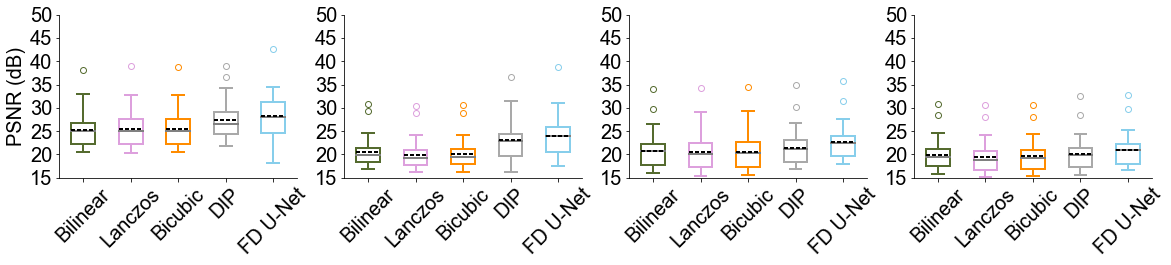

In [18]:
# Print subplots
method_c = ['darkolivegreen', 'plum', 'darkorange', 'darkgray', 'skyblue']
lw = 2
meanpointprops = dict(linewidth=lw, color='k', linestyle='-')
medianpointprops = dict(linewidth=lw, color='gray')
boxprops = dict(linewidth=lw)
flineprops = dict(linewidth=lw)
fname = 'Arial'
for j in range(len(metrics)):
    fig = plt.figure(figsize=(40,3))
    for i in range(len(pattern)-4,len(pattern)):
        ax = fig.add_subplot(1, len(pattern), i+1)
        if j == 0:
            ax.set_title(pattern_n[i], fontsize=fsize, fontname=fname)
            bp = plt.boxplot([s_bilinear[i, :], s_lanczos[i, :], s_bicubic[i, :], s_dip[i, :], s_dl[i, :]], 
                        boxprops=boxprops, medianprops=medianpointprops, whiskerprops=flineprops, capprops=flineprops,
                       showmeans=True, meanline=True, meanprops=meanpointprops, patch_artist=True)
            plt.ylim(top=1.2, bottom=0.2)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            for patch, flier, mean, color in zip(bp['boxes'], bp['fliers'], bp['means'], method_c):
                flier.set(markeredgecolor=color)
                mean.set_linestyle('--')
                mean.set_dashes((2, 1, 2, 1))
                patch.set_edgecolor(color)
                patch.set_facecolor('white')
            count = 0
            for wker, cap in zip(bp['whiskers'], bp['caps']):
                wker.set(color=method_c[count//2])
                cap.set(color=method_c[count//2])
                count += 1
        if j == 1:
            bp = plt.boxplot([p_bilinear[i, :], p_lanczos[i, :], p_bicubic[i, :], p_dip[i, :], p_dl[i, :]], 
                        boxprops=boxprops, medianprops=medianpointprops, whiskerprops=flineprops, capprops=flineprops,
                       showmeans=True, meanline=True, meanprops=meanpointprops, patch_artist=True)
            plt.ylim(top=50, bottom=15)
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            for patch, flier, mean, color in zip(bp['boxes'], bp['fliers'], bp['means'], method_c):
                flier.set(markeredgecolor=color)
                mean.set_linestyle('--')
                mean.set_dashes((2, 1, 2, 1))
                patch.set_edgecolor(color)
                patch.set_facecolor('white')
            count = 0
            for wker, cap in zip(bp['whiskers'], bp['caps']):
                wker.set(color=method_c[count//2])
                cap.set(color=method_c[count//2])
                count += 1
        if i == len(pattern)-4:
            plt.ylabel(metrics[j], fontsize=fsize, fontname=fname)
        plt.xticks([1, 2, 3, 4, 5], method, 
                   fontsize=fsize, fontname=fname)
        plt.xticks(rotation=45)
        plt.yticks(fontsize=fsize, fontname=fname)
    
    plt.show()

In [19]:
# Calculate mean SSIM
s_dip_mean = np.mean(s_dip, axis=1)
s_bicubic_mean = np.mean(s_bicubic, axis=1)
s_dl_mean = np.mean(s_dl, axis=1)
s_bilinear_mean = np.mean(s_bilinear, axis=1)
s_lanczos_mean = np.mean(s_lanczos, axis=1)
s_mean = (np.squeeze(np.dstack((s_bilinear_mean, s_lanczos_mean, s_bicubic_mean,
                               s_dip_mean, s_dl_mean))))

# Calculate mean PSNR
p_dip_mean = np.mean(p_dip, axis=1)
p_bicubic_mean = np.mean(p_bicubic, axis=1)
p_dl_mean = np.mean(p_dl, axis=1)
p_bilinear_mean = np.mean(p_bilinear, axis=1)
p_lanczos_mean = np.mean(p_lanczos, axis=1)
p_mean = (np.squeeze(np.dstack((p_bilinear_mean, p_lanczos_mean, p_bicubic_mean,
                               p_dip_mean, p_dl_mean))))

In [20]:
s_mean

array([[0.95108734, 0.95669916, 0.95781847, 0.93967934, 0.96916215],
       [0.87420429, 0.87318066, 0.87699685, 0.92811583, 0.944545  ],
       [0.84036955, 0.83595636, 0.84245504, 0.90268466, 0.91043518],
       [0.84385244, 0.84536118, 0.84938295, 0.92438774, 0.93933216],
       [0.78627893, 0.79364074, 0.80143328, 0.85333294, 0.88140281],
       [0.54641159, 0.52936948, 0.54237131, 0.69303655, 0.75601642],
       [0.55186681, 0.54360206, 0.55792618, 0.60792388, 0.65405096],
       [0.49816642, 0.48503897, 0.50084354, 0.52697677, 0.56340168]])

In [21]:
# Calculate standard dev SSIM
s_dip_std = np.std(s_dip, axis=1)
s_bicubic_std = np.std(s_bicubic, axis=1)
s_dl_std = np.std(s_dl, axis=1)
s_bilinear_std = np.std(s_bilinear, axis=1)
s_lanczos_std = np.std(s_lanczos, axis=1)
s_std = (np.squeeze(np.dstack((s_bilinear_std, s_lanczos_std, s_bicubic_std,
                                        s_dip_std, s_dl_std))))

# Calculate standard dev PSNR
p_dip_std = np.std(p_dip, axis=1)
p_bicubic_std = np.std(p_bicubic, axis=1)
p_dl_std = np.std(p_dl, axis=1)
p_bilinear_std = np.std(p_bilinear, axis=1)
p_lanczos_std = np.std(p_lanczos, axis=1)
p_std = (np.squeeze(np.dstack((p_bilinear_std, p_lanczos_std, p_bicubic_std,
                                        p_dip_std, p_dl_std))))

In [22]:
s_std

array([[0.01978325, 0.02001171, 0.01867417, 0.04050078, 0.01829478],
       [0.04207595, 0.04649173, 0.04499622, 0.03573441, 0.02575159],
       [0.05391565, 0.05937683, 0.05859954, 0.04707746, 0.0388791 ],
       [0.05024837, 0.05350992, 0.05155541, 0.03618472, 0.02637174],
       [0.07247971, 0.07699818, 0.07341527, 0.05369615, 0.05478771],
       [0.09607879, 0.09651514, 0.0949607 , 0.10874671, 0.09649196],
       [0.13389424, 0.13894569, 0.13947183, 0.13118333, 0.10124719],
       [0.11902608, 0.11974206, 0.12078009, 0.12007008, 0.12085957]])

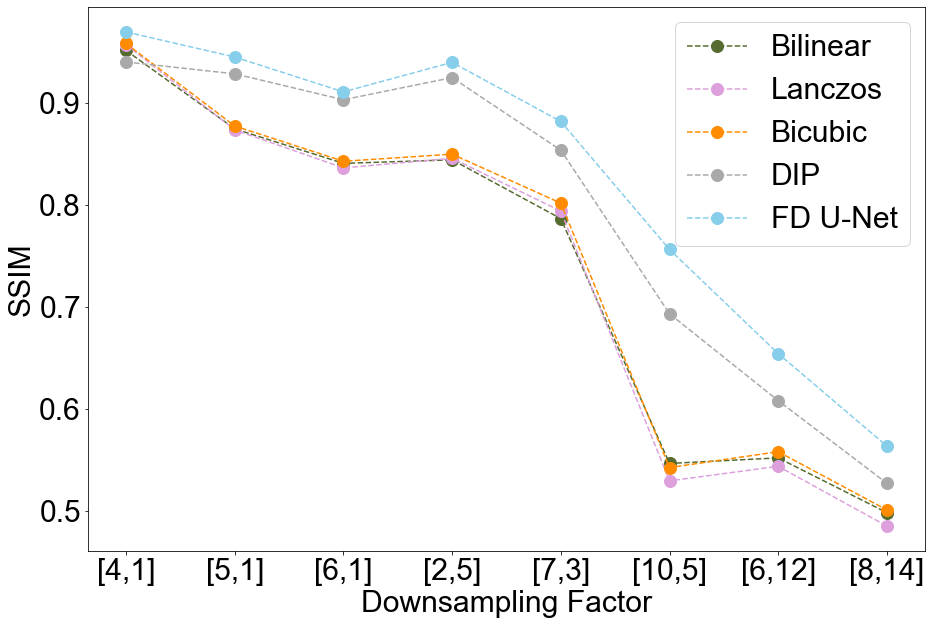

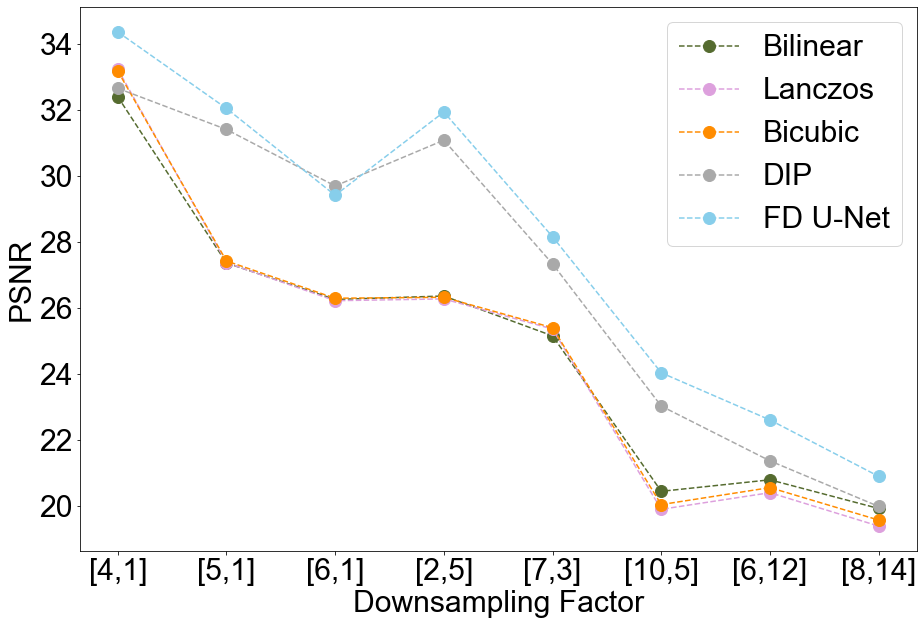

In [23]:
fsize = 30
fig = plt.figure(figsize=(15,10))
for i in range(s_mean.shape[1]):
#     plt.errorbar(np.arange(0, s_mean.shape[0]), s_mean[:,i],
#                 yerr=s_std[:,i], fmt='o', label=method[i], 
#                  capsize=5, mfc=method_c[i], mec=method_c[i],
#                 ecolor=method_c[i])
#     plt.scatter(np.arange(0, s_mean.shape[0]), s_mean[:,i], 
#                 label=method[i], facecolor=method_c[i])
    plt.plot(np.arange(0, s_mean.shape[0]), s_mean[:,i], '--bo',
                label=method[i], color=method_c[i], markersize=12)
plt.ylabel('SSIM', fontsize=fsize, fontname=fname)
plt.xlabel('Downsampling Factor', fontsize=fsize, fontname=fname)
plt.yticks(fontsize=fsize, fontname=fname)
plt.xticks(np.arange(0, len(pattern)), pattern_n, fontsize=fsize, fontname=fname)
plt.rc('legend',fontsize=fsize) 
plt.rc('font',family=fname) 
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,10))
for i in range(p_mean.shape[1]):
#     plt.errorbar(np.arange(0, p_mean.shape[0]), p_mean[:,i],
#                 yerr=p_std[:,i], fmt='o', label=method[i], 
#                  capsize=5, mfc=method_c[i], mec=method_c[i],
#                 ecolor=method_c[i])
#     plt.scatter(np.arange(0, s_mean.shape[0]), p_mean[:,i], 
#                 label=method[i], facecolor=method_c[i])
    plt.plot(np.arange(0, s_mean.shape[0]), p_mean[:,i], '--bo',
                label=method[i], color=method_c[i], markersize=12)
plt.ylabel('PSNR', fontsize=fsize, fontname=fname)
plt.xlabel('Downsampling Factor', fontsize=fsize, fontname=fname)
plt.yticks(fontsize=fsize, fontname=fname)
plt.xticks(np.arange(0, len(pattern)), pattern_n, fontsize=fsize, fontname=fname)
plt.rc('legend',fontsize=fsize) 
plt.rc('font',family=fname) 
plt.legend()
plt.show()

In [24]:
np.savetxt('.\Data\ssim_mean.csv', s_mean, delimiter=",")

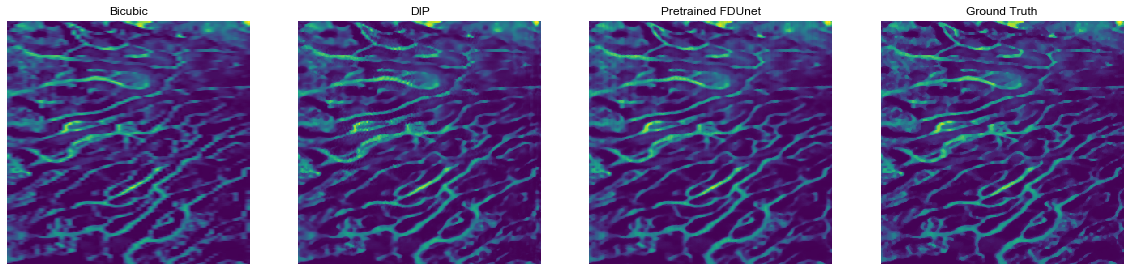

In [27]:
idx = [1, 1]
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 2)
ax.set_title("DIP")
plt.imshow(dip[:, :, idx[0], idx[1]])
plt.axis('off')
ax = fig.add_subplot(1, 4, 1)
ax.set_title("Bicubic")
plt.imshow(bicubic[:, :, idx[0], idx[1]])
plt.axis('off')
ax = fig.add_subplot(1, 4, 3)
ax.set_title("Pretrained FDUnet")
plt.imshow(dl[:, :, idx[0], idx[1]])
plt.axis('off')
ax = fig.add_subplot(1, 4, 4)
ax.set_title("Ground Truth")
plt.imshow(gt[:, :, idx[0], idx[1]])
plt.axis('off')
plt.show()

In [28]:
idx = [-5, 19]
print(pattern[idx[0]])
print(s_bilinear[idx[0], idx[1]])
print(s_bicubic[idx[0], idx[1]])
print(s_lanczos[idx[0], idx[1]])
print(s_dip[idx[0], idx[1]])
print(s_dl[idx[0], idx[1]])

2_5
0.8068680317290466
0.8095735253882422
0.8062997774515774
0.947649434559581
0.9516238518864492


In [29]:
print(pattern[idx[0]])
print(p_bilinear[idx[0], idx[1]])
print(p_bicubic[idx[0], idx[1]])
print(p_lanczos[idx[0], idx[1]])
print(p_dip[idx[0], idx[1]])
print(p_dl[idx[0], idx[1]])

2_5
25.02574374727231
24.78508803212049
24.72629701913671
32.3003872736982
32.967210026087784


### Process phantom data

In [30]:
fpath = './Data/phantom_img_results/phantom_output_imgs_'
pattern_pt = ['4-1', '5-1', '6-1', '7-3', '10-5']
wl = [532, 590]
s_dip = np.zeros((len(pattern_pt), len(wl)))
s_bilinear = np.zeros((len(pattern_pt), len(wl)))
s_bicubic = np.zeros((len(pattern_pt), len(wl)))
s_lanczos = np.zeros((len(pattern_pt), len(wl)))
s_dl = np.zeros((len(pattern_pt), len(wl)))
p_dip = np.zeros((len(pattern_pt), len(wl)))
p_bilinear = np.zeros((len(pattern_pt), len(wl)))
p_lanczos = np.zeros((len(pattern_pt), len(wl)))
p_bicubic = np.zeros((len(pattern_pt), len(wl)))
p_dl = np.zeros((len(pattern_pt), len(wl)))
dip = np.zeros((1042, 750, len(pattern_pt), len(wl)))
bicubic = np.copy(dip)
bilinear = np.copy(dip)
lanczos = np.copy(dip)
gt = np.copy(dip)
dl = np.copy(dip)

count_p =  1
for i in pattern_pt:
    count_f = 1
    for j in wl:
        duke_ori = cv2.imread(fpath + i + '/Duke_' + str(j) + '.png')
        duke_dip = cv2.imread(fpath + i + '/Duke_' + str(j) + '_dip_out.png')

        im_gt = duke_ori[:, :, -1]
        im_dip = duke_dip[:duke_ori.shape[0], :duke_ori.shape[1], 1]
        im_mask = duke_dip[:duke_ori.shape[0], :duke_ori.shape[1], 0]
        im_masked = im_gt*(im_mask/255)

        im_down = im_masked[im_mask!=0]
        [x_down, y_down] = np.where(im_mask!=0)
        x_down = np.unique(x_down)
        y_down = np.unique(y_down)
        #     print(x_down, y_down)
        im_down = im_down.reshape(len(x_down), len(y_down))
        im_bicubic = cv2.resize(im_down, (im_gt.shape[1], im_gt.shape[0]),
                            interpolation=cv2.INTER_CUBIC)
        im_bilinear = cv2.resize(im_down, (im_gt.shape[1], im_gt.shape[0]),
                            interpolation=cv2.INTER_LINEAR)
        im_lanczos = cv2.resize(im_down, (im_gt.shape[1], im_gt.shape[0]),
                            interpolation=cv2.INTER_LANCZOS4)

        duke_dl = cv2.imread(fpath + i + '/deep_learning/Duke_' + str(j) + '.png')
        im_dl = duke_dl[:duke_ori.shape[0], :duke_ori.shape[1], 0]
        
        # Save ssim values
        s_dip[count_p-1, count_f-1] = ssim(im_dip, im_gt, data_range=255)
        s_bicubic[count_p-1, count_f-1] = ssim(im_bicubic, im_gt, data_range=255)
        s_dl[count_p-1, count_f-1] = ssim(im_dl, im_gt, data_range=255)
        s_bilinear[count_p-1, count_f-1] = ssim(im_bilinear, im_gt, data_range=255)
        s_lanczos[count_p-1, count_f-1] = ssim(im_lanczos, im_gt, data_range=255)
        
        # Save psnr values
        p_dip[count_p-1, count_f-1] = psnr(im_gt, im_dip)
        p_bicubic[count_p-1, count_f-1] = psnr(im_gt, im_bicubic)
        p_dl[count_p-1, count_f-1] = psnr(im_gt, im_dl)
        p_bilinear[count_p-1, count_f-1] = psnr(im_gt, im_bilinear)
        p_lanczos[count_p-1, count_f-1] = psnr(im_gt, im_lanczos)
        
#         # Save images
#         dip[:, :, count_p-1, count_f-1] = im_dip
#         bicubic[:, :, count_p-1, count_f-1] = im_bicubic
#         dl[:, :, count_p-1, count_f-1] = im_dl
#         bilinear[:, :, count_p-1, count_f-1] = im_bilinear
#         lanczos[:, :, count_p-1, count_f-1] = im_lanczos
#         gt[:, :, count_p-1, count_f-1] = im_gt

        count_f += 1
        if count_f > batch:
            break
    
    count_p += 1



C:\Users\PI-Lab\AppData\Local\Programs\Python\Python36\lib\site-packages\skimage\measure\simple_metrics.py:127: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [31]:
print(np.mean(s_bilinear, axis=1))
print(np.mean(s_bicubic, axis=1))
print(np.mean(s_lanczos, axis=1))
print(np.mean(s_dip, axis=1))
print(np.mean(s_dl, axis=1))

[0.93508335 0.84321534 0.77914146 0.67820804 0.55598421]
[0.93755369 0.8352164  0.76460255 0.65953486 0.51618528]
[0.93757886 0.83101053 0.75756524 0.64752103 0.50032213]
[0.76176485 0.74542011 0.77471845 0.66251817 0.59557283]
[0.90979331 0.85866202 0.8499466  0.69901255 0.64012536]


In [32]:
print(np.mean(p_bilinear, axis=1))
print(np.mean(p_bicubic, axis=1))
print(np.mean(p_lanczos, axis=1))
print(np.mean(p_dip, axis=1))
print(np.mean(p_dl, axis=1))

[30.68374895 25.62685429 23.58110098 22.95126821 19.49275439]
[30.98248776 25.43510735 23.28039641 22.65584777 19.06499833]
[31.01389029 25.34749837 23.1838863  22.5019549  18.92660913]
[26.04823776 25.50736853 25.41349717 23.59659508 22.38712589]
[24.73412695 27.9837813  28.02543979 25.19806383 22.93119185]


### Training Time

In [33]:
# Read all loss of each output
# pattern = ['4_1', '5_1']
pattern = ['4_1', '5_1', '6_1', '2_5', '7_3', '10_5', '6_12', '8_14']
count_p = 0

for p in pattern:
    count_f = 0
    if p == '5_2':
        imgpath = imgroot + '/' + '2_5'
    elif p == '12_6':
        imgpath = imgroot + '/' + '6_12'
    elif p == '14_8':
        imgpath = imgroot + '/' + '8_14'
    else:
        imgpath = imgroot + '/' + p
    list_dir = os.listdir(imgpath)
    list_file = [f for f in list_dir if isfile(join(imgpath, f))]
    for f in list_file:        
#         print('Current count: ' + str(count_f))
        
        imgname, imgsuffix = f.split('.')
        if imgsuffix != 'png':
            continue

#         im = cv2.imread(imgpath + '/' + f)
#         im2 = cv2.imread(imgpath + '/deep_learning/' + imgname + '.' + imgsuffix)
        im2 = cv2.imread(imgpath + '/output/' + imgname + '_dip_out.' + imgsuffix)
        
#         print(imgpath + '/output/' + imgname + '_dip_out.' + imgsuffix)
        
        if im2 is None:
            continue
            
        print(imgpath + '/output/' + imgname + '_dip_out.' + imgsuffix)
            
        if count_f == 0:
            l_msef = np.loadtxt(imgpath + '/output/' + imgname + '_loss.txt') 
            l_msef = l_msef[:,0]
            t_time = np.loadtxt(imgpath + '/output/' + imgname + '_Aux.txt')        
        else:
            temp = np.loadtxt(imgpath + '/output/' + imgname + '_loss.txt') 
            temp = temp[:,0]
            l_msef = np.c_[l_msef,temp]
            t_time = np.append(t_time,np.loadtxt(imgpath + '/output/' + imgname + '_Aux.txt'))
        
        count_f += 1
        
    if count_p == 0:
        l_mse = l_msef
        ttime = t_time
    else:
        l_mse = np.dstack((l_mse,l_msef))
        ttime = np.c_[ttime,t_time]
        
    count_p += 1

./Data/4_1/output/20190411_EpiInj_thinnedskull 2_Image0_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190412_EpiInj_thinnedskull 3_Image0_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190412_EpiInj_thinnedskull2 3_Image0_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190423_thinnedskull_Epi 11_Image7_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190425_thinnedskull_Epi 19_Image11_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190516_practice&oldmice   4_Image1_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190529_findfocus  24_Image0_index0_1-12_1-4_dip_out.png
./Data/4_1/output/20190529_findfocus  24_Image12_index0_1-12_1-4_dip_out.png
./Data/4_1/output/532_OR_398_index0_1-12_1-4_dip_out.png
./Data/4_1/output/532_OR_39_index0_1-12_1-4_dip_out.png
./Data/4_1/output/532_OR_40_index0_1-12_1-4_dip_out.png
./Data/4_1/output/532_OR_542_index0_1-12_1-4_dip_out.png
./Data/4_1/output/532_OR_545_index0_1-12_1-4_dip_out.png
./Data/4_1/output/532_OR_57_index0_1-12_1-4_dip_out.png
./Data/

./Data/2_5/output/reslt_OR_1 (4)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_2 (20)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_2 (23)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_2 (28)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_2 (33)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_2 (5)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_3 (22)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_4 (15)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_4 (5)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_5 (13)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_5 (2)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_7 (4)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_9 (13)_index0_5-2_dip_out.png
./Data/2_5/output/reslt_OR_9 (4)_index0_5-2_dip_out.png
./Data/7_3/output/20190411_EpiInj_thinnedskull 2_Image0_index0_3-7_dip_out.png
./Data/7_3/output/20190412_EpiInj_thinnedskull 3_Image0_index0_3-7_dip_out.png
./Data/7_3/output/20190412_EpiInj_thinnedskull2 3_

./Data/8_14/output/532_OR_545_index0_14-8_dip_out.png
./Data/8_14/output/532_OR_57_index0_14-8_dip_out.png
./Data/8_14/output/532_OR_59_index0_14-8_dip_out.png
./Data/8_14/output/532_OR_63_index0_14-8_dip_out.png
./Data/8_14/output/532_OR_64_index0_14-8_dip_out.png
./Data/8_14/output/532_OR_71_index0_14-8_dip_out.png
./Data/8_14/output/532_OR_82_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_1 (14)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_1 (16)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_1 (2)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_1 (27)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_1 (4)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_2 (20)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_2 (23)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_2 (28)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_2 (33)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_2 (5)_index0_14-8_dip_out.png
./Data/8_14/output/reslt_OR_3 (22)_index0

In [37]:
# Calculate mean and error at each time point
l_mse_maxdiv = np.copy(l_mse)
# for i in range(l_mse.shape[-1]):
#     temp = l_mse[:,i]
#     l_mse_maxdiv[:,i] = temp/temp.max()
    
l_mean = np.mean(l_mse_maxdiv,axis=1)
l_err = np.std(l_mse_maxdiv,axis=1)

In [38]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
avg_w = 20
l_mean_avg = np.zeros((l_mean.shape[0]-avg_w+1, l_mean.shape[1]))
for i in range(l_mean.shape[-1]):
    l_mean_avg[:,i] = moving_average(l_mean[:,i], avg_w)

In [39]:
# # Plot loss of all patterns
# fig = plt.figure(figsize=(10,10))
# for i in range(l_mean.shape[-1]):  
#     print(i)
#     temp = l_mean_avg[:,i]
# #     temp = temp-temp.min()
# #     temp = temp/temp.max()
#     plt.plot(temp)
# #     plt.fill_between()
# #     plt.yscale('log')

# plt.yticks(fontsize=15, fontname=fname)
# plt.xticks(fontsize=15, fontname=fname)
# plt.xlim((0, 600))
# plt.legend(pattern_n)
# plt.rc('legend',fontsize=20) 
# plt.rc('font',family=fname) 
# plt.show()

### Iterations vs SSIM

In [46]:
# Read all loss of each output
# pattern = ['4_1', '5_1']
pattern = ['4_1', '5_1', '6_1', '2_5', '7_3', '10_5', '6_12', '8_14']

count_f = 0
imgpath = imgroot + '/' + pattern[1] + '/output_ssimiter'
list_dir = os.listdir(imgpath)
list_file = [f for f in list_dir if isfile(join(imgpath, f))]
shared_imgname = []

# Extract the shared samples that have the SSIM vs iterations log
for f in list_file:           
    count_p = 0
    
    try:
        imgname, imgsuffix = f.split('.')
    except:
        continue
        
    if imgsuffix != 'h5':
        continue
    
    imgname_split = imgname.split('_')
    check_name = '_'.join(imgname_split[:-1])
    
    count = 0
    for p in pattern:
        correct_p = '-'.join([p.split('_')[1],p.split('_')[0]])
        imgpath = imgroot + '/' + p
        if p == '4_1' or p == '6_1':
            path = imgpath + '/output_ssimiter/' + check_name + '_1-12_' + correct_p + '_dip_out.png'
        else:            
            path = imgpath + '/output_ssimiter/' + check_name + '_' + correct_p + '_dip_out.png'
        
        im2 = cv2.imread(path)

        if im2 is None:
            continue
            
        count += 1
    
    if count == len(pattern):
        shared_imgname.append(check_name)
                
print(shared_imgname)

['20190425_thinnedskull_Epi 19_Image11_index0', '20190529_findfocus  24_Image12_index0', 'reslt_OR_1 (14)_index0']


In [47]:
#         print(imgpath + '/output_ssimiter/' + imgname + '_dip_out.' + imgsuffix)
count_f = 0
for imgname in shared_imgname:           
    count_p = 0
    
    for p in pattern:
        
        correct_p = '-'.join([p.split('_')[1],p.split('_')[0]])
        imgpath = imgroot + '/' + p
        if p == '4_1' or p == '6_1':
            path = imgpath + '/output_ssimiter/' + imgname + '_1-12_' + correct_p
        else:            
            path = imgpath + '/output_ssimiter/' + imgname + '_' + correct_p
        
        if count_p == 0:
            ssimf = np.loadtxt(path + '_SSIMIter.txt') 
            psnrf = np.loadtxt(path + '_PSNRIter.txt')     
        else:
            temp = np.loadtxt(path + '_SSIMIter.txt') 
#             temp = temp[:,0]
            ssimf = np.c_[ssimf,temp]
            temp = np.loadtxt(path + '_PSNRIter.txt') 
#             temp = temp[:,0]
            psnrf = np.c_[psnrf,temp]
#         print(count_p)

        count_p += 1
    
#     print(count_f)
    if count_f == 0:
        ssim = ssimf
        psnr = psnrf
    else:
        ssim = np.dstack((ssim,ssimf))
        psnr = np.dstack((psnr,psnrf))

    count_f += 1

In [48]:
ssim.shape

(5000, 8, 3)

In [49]:
# Calculate mean and error at each time point
ssim_maxdiv = np.copy(ssim)
# for i in range(l_mse.shape[-1]):
#     temp = l_mse[:,i]
#     l_mse_maxdiv[:,i] = temp/temp.max()
    
ssim_mean = np.mean(ssim_maxdiv,axis=2)
ssim_err = np.std(ssim_maxdiv,axis=2)

In [50]:
# Calculate mean and error at each time point
psnr_maxdiv = np.copy(psnr)
# for i in range(l_mse.shape[-1]):
#     temp = l_mse[:,i]
#     l_mse_maxdiv[:,i] = temp/temp.max()
    
psnr_mean = np.mean(psnr_maxdiv,axis=2)
psnr_err = np.std(psnr_maxdiv,axis=2)

In [51]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
avg_w = 20
ssim_mean_avg = np.zeros((ssim_mean.shape[0]-avg_w+1, ssim_mean.shape[1]))
for i in range(ssim_mean.shape[-1]):
    ssim_mean_avg[:,i] = moving_average(ssim_mean[:,i], avg_w)

In [52]:
psnr_mean_avg = np.zeros((psnr_mean.shape[0]-avg_w+1, psnr_mean.shape[1]))
for i in range(psnr_mean.shape[-1]):
    psnr_mean_avg[:,i] = moving_average(psnr_mean[:,i], avg_w)

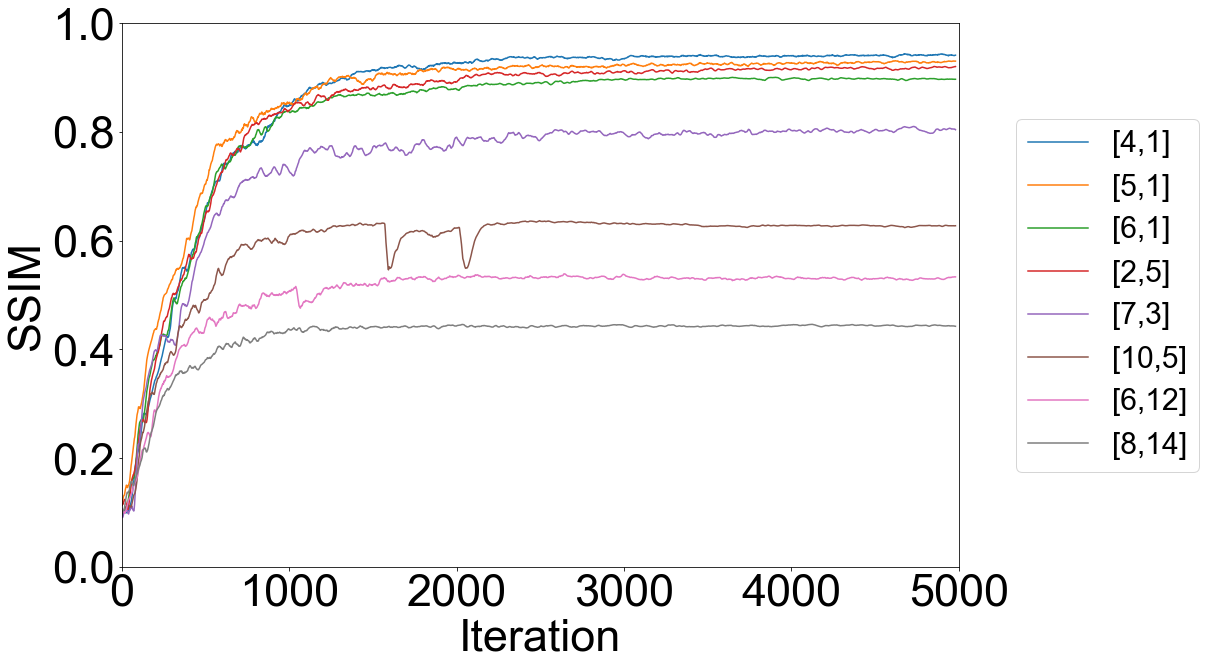

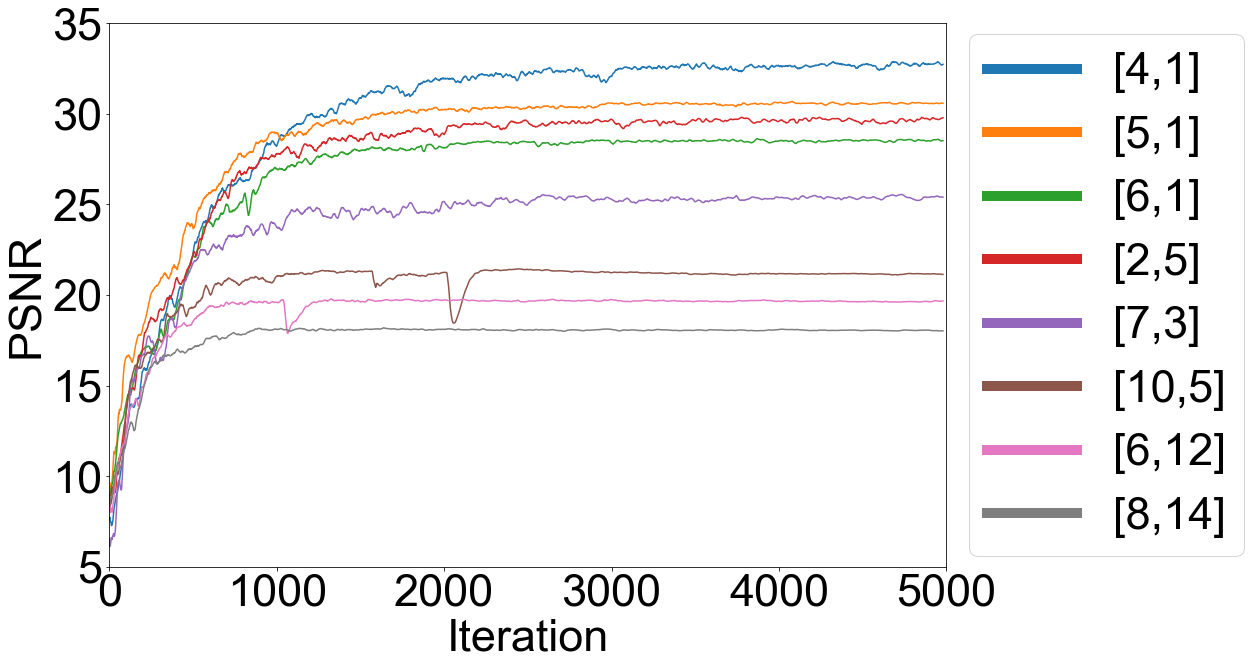

In [53]:
fsize = 45
# Plot loss of all patterns - SSIM
fig = plt.figure(figsize=(15,10))
for i in range(ssim_mean.shape[-1]):  
    temp = ssim_mean_avg[:,i]
#     temp = temp-temp.min()
#     temp = temp/temp.max()
    plt.plot(temp)
#     plt.fill_between()
#     plt.yscale('log')

plt.ylabel('SSIM', fontsize=fsize, fontname=fname)
plt.xlabel('Iteration', fontsize=fsize, fontname=fname)
plt.yticks(fontsize=fsize, fontname=fname)
plt.xticks(fontsize=fsize, fontname=fname)
plt.ylim((0, 1))
plt.xlim((0, 5000))
plt.legend(pattern_n, loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.rc('legend',fontsize=fsize) 
plt.rc('font',family=fname) 
plt.show()

# Plot loss of all patterns - PSNR
fig = plt.figure(figsize=(15,10))
for i in range(psnr_mean.shape[-1]):  
    temp = psnr_mean_avg[:,i]
#     temp = temp-temp.min()
#     temp = temp/temp.max()
    plt.plot(temp)
#     plt.fill_between()
#     plt.yscale('log')

plt.ylabel('PSNR', fontsize=fsize, fontname=fname)
plt.xlabel('Iteration', fontsize=fsize, fontname=fname)
plt.yticks(fontsize=fsize, fontname=fname)
plt.xticks(fontsize=fsize, fontname=fname)
plt.ylim((5, 35))
plt.xlim((0, 5000))
leg = plt.legend(pattern_n, loc='center left', bbox_to_anchor=(1, 0.5))
# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(10)
plt.rc('legend',fontsize=fsize) 
plt.rc('font',family=fname) 
plt.show()